# Solutions for Lesson 3: Main Project

Don't look at this notebook until you have attempted to solve the problems yourself.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn.datasets
import torch
from torch import nn
from torch import optim

<br><br><br><br><br>

## Project 1: classify jets with a neural network

### Step 0: Put your name on the results sheet

...

<br><br><br><br><br>

### Step 1: Download and understand the data

In [2]:
hls4ml_lhc_jets_hlf = sklearn.datasets.fetch_openml("hls4ml_lhc_jets_hlf")

features, targets = hls4ml_lhc_jets_hlf["data"], hls4ml_lhc_jets_hlf["target"]

<br><br><br><br><br>

### Step 2: Split the data into training, validation, and test samples

I chose to use PyTorch's [torch.utils.data.random_split](https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split) function, which returns [torch.utils.data.Subset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Subset) objects instead of [torch.Tensor](https://pytorch.org/docs/stable/tensors.html)s.

Because of this choice, I followed through with PyTorch's other data-handling tools, like [torch.utils.data.TensorDataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset) and [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) instead of forcing everything back into `torch.Tensor` early. The [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) made mini-batching easier.

In [3]:
dataset = torch.utils.data.TensorDataset(
    torch.tensor(features.values).float(),
    torch.tensor(targets.cat.codes.values).long(),
)

In [4]:
subset_training, subset_validation, subset_test = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1])

<br><br><br><br><br>

### Step 3: Build a classifier neural network

Not all of the features are close to the interval $(-1, 1)$, so we should normalize each column to have zero mean and unit standard deviation.

Since this is a machine-optimized part of the fit, it should be applied to the training sample only.

In [5]:
class NormalizeInput(nn.Module):
    def __init__(self, subset_training):
        super().__init__()

        # get a single features tensor for the whole training subset
        ((features_tensor, targets_tensor),) = torch.utils.data.DataLoader(subset_training, batch_size=len(targets))

        # get 16 means and 16 standard deviations from the training dataset
        self.register_buffer("means", features_tensor.mean(axis=0))
        self.register_buffer("stds", features_tensor.std(axis=0))

    def forward(self, x):
        return (x - self.means) / self.stds

In [6]:
normalize_input = NormalizeInput(subset_training)

In [7]:
model_without_softmax = nn.Sequential(
    normalize_input,
    nn.Linear(16, 32),   # 16 input features → a hidden layer with 32 neurons
    nn.ReLU(),           # ReLU avoids the vanishing gradients problem
    nn.Linear(32, 32),   # first hidden layer → second hidden layer
    nn.ReLU(),
    nn.Linear(32, 32),   # second hidden layer → third hidden layer
    nn.ReLU(),
    nn.Linear(32, 5),    # third hidden layer → 5 output category probabilities
    # no softmax because CrossEntropyLoss automatically applies it
)

<br><br><br><br><br>

### Step 4: Monitor the loss function

The following fits the model with loss function monitoring integrated into the loop.

In [8]:
NUM_EPOCHS = 10
BATCH_SIZE = 20000

# DataLoader lets us iterate over mini-batches, given a Subset
training_loader = torch.utils.data.DataLoader(subset_training, batch_size=BATCH_SIZE)
# the validation sample doesn't need to be batched, so we make it one big batch
validation_loader = torch.utils.data.DataLoader(subset_validation, batch_size=len(subset_validation))

loss_function = nn.CrossEntropyLoss()

optimizer = optim.Adam(model_without_softmax.parameters(), lr=0.03)

# collect loss data versus epoch
validation_loss_vs_epoch = []
training_loss_vs_epoch = []

for epoch in range(NUM_EPOCHS):
    # this asserts that the validation_loader iterates over exactly one batch
    ((features_tensor, targets_tensor),) = validation_loader

    predictions_tensor = model_without_softmax(features_tensor)
    loss = loss_function(predictions_tensor, targets_tensor)
    validation_loss = loss.item() * len(targets_tensor) * (0.8 / 0.1)  # normalize!

    validation_loss_vs_epoch.append(validation_loss)

    # the training sample needs a mini-batch loop
    training_loss = 0
    for features_tensor, targets_tensor in training_loader:
        optimizer.zero_grad()
    
        predictions_tensor = model_without_softmax(features_tensor)
        loss = loss_function(predictions_tensor, targets_tensor)
        training_loss += loss.item() * len(targets_tensor)             # normalize!
    
        loss.backward()
        optimizer.step()

    training_loss_vs_epoch.append(training_loss)

    # print out partial quantities so we can discover mistakes early
    print(f"{epoch = } {training_loss = } {validation_loss = }")

epoch = 0 training_loss = 679462.8674983978 validation_loss = 1071309.778213501
epoch = 1 training_loss = 524077.6901245117 validation_loss = 552742.6261901855
epoch = 2 training_loss = 492119.0574169159 validation_loss = 504934.21268463135
epoch = 3 training_loss = 499181.45513534546 validation_loss = 487599.8682975769
epoch = 4 training_loss = 466484.87854003906 validation_loss = 473858.32834243774
epoch = 5 training_loss = 458092.9729938507 validation_loss = 463444.4236755371
epoch = 6 training_loss = 452338.95087242126 validation_loss = 456825.722694397
epoch = 7 training_loss = 448125.80919265747 validation_loss = 454250.8907318115
epoch = 8 training_loss = 445401.3786315918 validation_loss = 452019.907951355
epoch = 9 training_loss = 443272.4778652191 validation_loss = 446988.69943618774


<br><br><br><br><br>

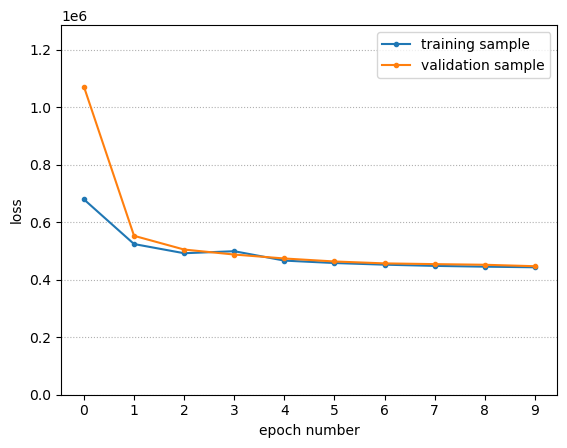

In [9]:
fig, ax = plt.subplots()

ax.plot(range(len(training_loss_vs_epoch)), training_loss_vs_epoch, marker=".")
ax.plot(range(len(validation_loss_vs_epoch)), validation_loss_vs_epoch, marker=".")

ax.grid(True, "both", "y", linestyle=":")

ax.set_xticks(range(NUM_EPOCHS))
ax.set_ylim(0, 1.2*max(max(training_loss_vs_epoch), max(validation_loss_vs_epoch)))
ax.set_xlabel("epoch number")
ax.set_ylabel("loss")
ax.legend(["training sample", "validation sample"])

None

With smaller `BATCH_SIZE`, it converges to the same final loss in a smaller number of epochs (less total time).

To make the above plot interesting, `BATCH_SIZE` was chosen larger than it needed to be!

I see no sign of overfitting. This dataset has a lot of data points and they are not degenerate (all laying in a line/plane/hyperplane) and the neural network is not too large for it. There's no need to add any regularization.

<br><br><br><br><br>

### Step 5: Compute a 5×5 confusion matrix

To compute predictions as probabilities, we'll need to apply the softmax function, so make a new model that has this included.

In [10]:
model_with_softmax = nn.Sequential(
    model_without_softmax,
    nn.Softmax(dim=1),
)

The first time you make this plot, it should use the validation sample (`validation_loader`).

Below, I'm using the test sample (`test_loader`) because I've already checked the validation sample and I won't be making any more changes to my model or fitting procedure.

In [11]:
test_loader = torch.utils.data.DataLoader(subset_test, batch_size=len(subset_test))

((features_tensor, targets_tensor),) = test_loader
predictions_tensor = model_with_softmax(features_tensor)

confusion_matrix = np.array(
    [
        [
            (predictions_tensor[targets_tensor == true_class].argmax(axis=1) == prediction_class).sum().item()
            for prediction_class in range(5)
        ]
        for true_class in range(5)
    ]
)
confusion_matrix

array([[12746,  2193,  1273,   260,   232],
       [ 2441, 11547,  1145,   533,   281],
       [ 1213,   497, 14035,   755,   299],
       [  703,  2696,   199, 13019,   213],
       [  737,  2507,   341,   946, 12189]])

<br><br><br><br><br>

A colorbar plot demonstrates the quality of this model: the diagonal (correct predictions) is much more populated than the off-diagonals.

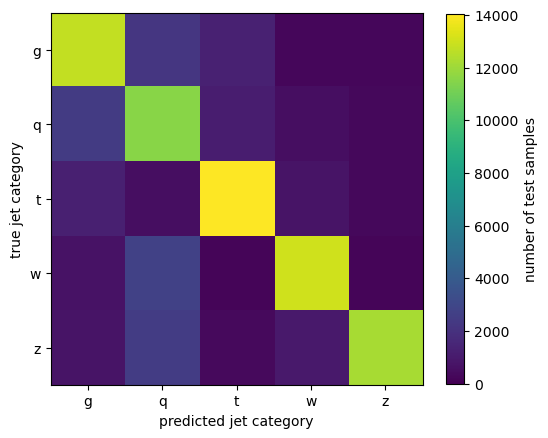

In [12]:
fig, ax = plt.subplots(figsize=(6, 6))

image = ax.imshow(confusion_matrix, vmin=0)
fig.colorbar(image, ax=ax, label="number of test samples", shrink=0.8)

ax.set_xticks(range(5), targets.cat.categories)
ax.set_yticks(range(5), targets.cat.categories)

ax.set_xlabel("predicted jet category")
ax.set_ylabel("true jet category")

None

<br><br><br><br><br>

### Step 6: Compute a 2×2 confusion matrix

The following selects true heavy/electroweak events using `is_heavy` and determines if the model predicts heavy/electroweak if the sum of the `'t'`, `'w'`, `'z'` probabilities is greater than the `threshold`.

It would have been entirely equivalent to define a true light/QCD selection as

```python
is_light = (targets_tensor < 2)
```

and a light/QCD prediction as

```python
selected_predictions[:, 0:2].sum(axis=1) <= threshold
```

Each (length-5) row vector in the predictions consists of non-overlapping probabilities that add up to 1 (by construction, because of the [softmax](https://en.wikipedia.org/wiki/Softmax_function)). So the sum of slice `0:2` is equal to 1 minus the sum of slice `2:5`.

In [13]:
def matrix_for_cutoff_decision_at(threshold):
    is_heavy = (targets_tensor >= 2)

    true_positive  = (predictions_tensor[is_heavy][:, 2:5].sum(axis=1) > threshold).sum().item()
    false_positive = (predictions_tensor[~is_heavy][:, 2:5].sum(axis=1) > threshold).sum().item()

    false_negative = (predictions_tensor[is_heavy][:, 2:5].sum(axis=1) <= threshold).sum().item()
    true_negative  = (predictions_tensor[~is_heavy][:, 2:5].sum(axis=1) <= threshold).sum().item()

    return np.array([
        [true_positive, false_positive],
        [false_negative, true_negative],
    ])

In [14]:
matrix_for_cutoff_decision_at(0.5)

array([[42374,  3985],
       [ 7975, 28666]])

<br><br><br><br><br>

Once we have 2×2 confusion matrices as a function of `threshold`, we can plot the ROC curve as in the lecture.

In [15]:
true_positive_rates = []
false_positive_rates = []

for threshold in np.linspace(0, 1, 1000):
    ((true_positive, false_positive),
     (false_negative, true_negative)) = matrix_for_cutoff_decision_at(threshold)

    true_positive_rates.append(true_positive / (true_positive + false_negative))
    false_positive_rates.append(false_positive / (true_negative + false_positive))

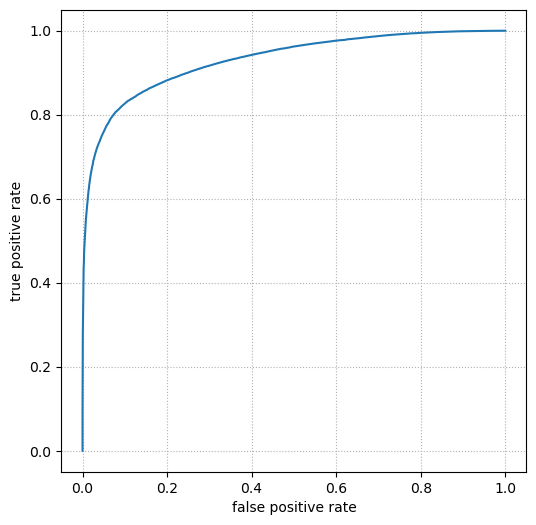

In [16]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(false_positive_rates, true_positive_rates)

ax.grid(True, linestyle=":")

ax.set_xlabel("false positive rate")
ax.set_ylabel("true positive rate")

None

<br><br><br><br><br>

### Step 7: Make a final ROC curve with the test sample and submit it

In [17]:
def resample_loss_curve(false_positive_rates, true_positive_rates):
    series = pd.Series(true_positive_rates, index=false_positive_rates).groupby(level=0).mean()
    new_x = np.linspace(0, 1, 100)**2
    new_y = series.reindex(series.index.union(new_x)).interpolate("values").loc[new_x]

    fig, ax = plt.subplots(figsize=(6, 6))

    ax.plot(new_x, new_y, marker=".")
    ax.plot(false_positive_rates, true_positive_rates)

    ax.grid(True, linestyle=":")

    ax.set_xlabel("false positive rate")
    ax.set_ylabel("true positive rate")

    print("Copy-paste the the following numbers into your column in the spreadsheet:")
    print("https://docs.google.com/spreadsheets/d/1nRtNJoxW1i-jCr04ZHUlfv0DU4tMGbyvCZcpXakYedE/edit?usp=sharing")
    print()
    print("\n".join(str(x) for x in new_y))
    print()
    print("Also, be sure that these two curves exactly overlap each other:")

Copy-paste the the following numbers into your column in the spreadsheet:
https://docs.google.com/spreadsheets/d/1nRtNJoxW1i-jCr04ZHUlfv0DU4tMGbyvCZcpXakYedE/edit?usp=sharing

0.018868299271087807
0.1289489537500241
0.20992296601213034
0.3068408331699649
0.3764086609582623
0.4303733732040816
0.46789693339936284
0.5027722975621793
0.5263397009737253
0.5538282184293029
0.576421400175596
0.6020473392019997
0.6217746215633688
0.6441249222352274
0.661624364595204
0.6776505449134138
0.692287862350221
0.7049561472411193
0.7174712900647694
0.7281837346960565
0.7378146856743826
0.7487390867575362
0.758157035088498
0.7678773983598631
0.7770101383931396
0.7856509131380228
0.7942924103010204
0.8015956392972097
0.808012611508453
0.8131647637597922
0.8193828345366969
0.8250768417618952
0.8305736233849017
0.8350616401223167
0.8392843804747505
0.8434586349887045
0.8485805236474203
0.8527170936260542
0.8568358995984942
0.8609808586570786
0.8650308151756928
0.8690270266969874
0.8728376091527816
0.876807

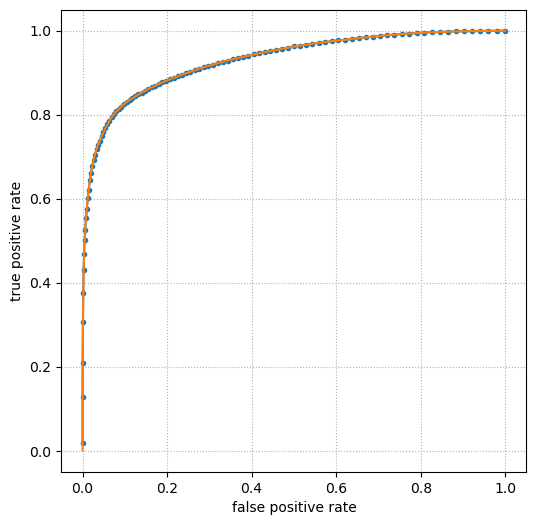

In [18]:
resample_loss_curve(false_positive_rates, true_positive_rates)

This is what I put in the "Jim Pivarski" column of the [Google Spreadsheet for this course](https://docs.google.com/spreadsheets/d/1nRtNJoxW1i-jCr04ZHUlfv0DU4tMGbyvCZcpXakYedE/edit?usp=sharing).

There's no reason to think this is the best ROC curve possible: try to beat mine!